In [126]:
from openai import OpenAI
import re

client = OpenAI(
    api_key = "c8a7e43e-cce1-4d61-af75-de350b7e5731",
    base_url = "https://ark.cn-beijing.volces.com/api/v3",
)

In [127]:
import argparse
import pdb

from builder import build
from util import DEFAULTS

In [128]:
# print("----- standard request -----")
# completion = client.chat.completions.create(
#     model = "deepseek-r1-250120",  # your model endpoint ID
#     messages = [
#         {
#             "role": "user", 
#             "content": "1+1=?"
#         },
#     ],
# )

In [129]:
# print("----- Reasoning content -----")
# print(completion.choices[0].message.reasoning_content)

In [130]:
# print("----- Content -----")
# print(completion.choices[0].message.content)

In [131]:
filename = '..\grammar_example.txt'
with open(filename) as file:
        grammer_example = [line for line in file]
grammer_example = ''.join(grammer_example)

In [ ]:
quest = '根据文档中的GMBL的语法和示例，使用GMBL语法，生成一道角度计算相关的简单几何题的代码。请确保每个点在使用前都已经定义过，确保符合示例的GMBL语法，确保每一句语句都写在同一行，确保GMBL输入的角度是弧度制，确保没有直接定义数值对象。'

In [133]:
messages = [{
    "role": "user", 
    "content": grammer_example + '\n\n' + quest
    }]

In [134]:
response = client.chat.completions.create(
    # 替换 <Model> 为模型的Model ID
    model="deepseek-r1-250120",
    messages=messages,
    stream=True,
)
reasoning_content = ""
content = ""

for chunk in response:
    if hasattr(chunk.choices[0].delta, 'reasoning_content') and chunk.choices[0].delta.reasoning_content:
        reasoning_content += chunk.choices[0].delta.reasoning_content
        print(chunk.choices[0].delta.reasoning_content, end="")
    else:
        content += chunk.choices[0].delta.content
        print(chunk.choices[0].delta.content, end="")

好的，我需要根据用户的要求，使用GMBL语法生成一道角度计算相关的几何题。首先，我需要回顾一下用户提供的文档内容，确保自己正确理解各个函数、断言和参数化的用法。

用户希望题目涉及角度计算，所以可能需要用到uangle这个函数来获取角度值，然后在eval中使用等式或比较断言来验证某个角度是否符合预期。同时，要确保每个点在使用前都已定义，并且符合GMBL的语法规则，比如先定义点、线、圆等对象，再使用它们进行断言或计算。

接下来，考虑构造一个三角形，可能需要使用param来参数化一个三角形，比如使用acute-tri（锐角三角形）或者iso-tri（等腰三角形），这样可以确保某些角度特性。例如，可以创建一个等腰三角形，然后通过计算某些中点或垂线，形成其他点，进而计算角度。

例如，构造一个等腰三角形ABC，其中AB=AC，然后计算其某个点的垂足或者中点，再验证某个角度是否为特定值。或者，考虑三角形的内心、外心等特殊点，这些点可能涉及角平分线，从而产生特定角度。

不过，用户提到要确保没有直接定义数值对象，所以可能需要通过运算来构造角度值，例如使用mul和pi来组合，比如将pi乘以0.25表示45度（π/4弧度）。同时，要避免直接写数字，而是通过运算表达式来生成数值。

比如，设定一个三角形的两个角，然后通过三角形内角和为π的性质，计算第三个角，并在eval中验证是否符合。

举个例子：

1. 参数化一个三角形ABC，例如等腰三角形。
2. 定义某个中点或垂线，如垂足或重心。
3. 使用uangle函数获取某个角度，并通过运算（如mul、div）来构造预期的角度值。
4. 在eval中断言该角度等于计算后的值。

具体步骤可能如下：

- 使用(param (A B C) (iso-tri B))定义等腰三角形，其中B为顶点，BA=BC。
- 定义D为B到AC边的垂足（使用foot函数）。
- 计算角ABD的角度是否等于某个值，比如π/4。
- 但是需要确保角度计算基于几何关系，比如通过已知角度推导。

或者，考虑构造一个直角三角形，其中已知一个角为π/4，另一个为π/4，那么第三个角应为π/2。但这样可能太简单，需要更复杂的情况。

另一个例子是，使用三角形ABC，并定义其中点M、N，连接线段，形成新的角，然后验证该角是否为特定值。例如，在三角形中，中点连线可能形成

In [135]:
print(content)
content



```gmb
(param (A B C) (iso-tri A))
(assert (= (uangle B A C) (mul pi (div 2 5))))
(define D point (midp B C))
(define E point (foot D (line A B)))
(eval (= (uangle A D E) (mul pi (div 1 5))))
```

该代码构造了一个顶角为2π/5的等腰三角形ABC，定义中点D后作D到AB边的垂足E，最后验证角ADE的度数为π/5。通过等腰三角形性质、中点定义和垂足操作，形成角度验证关系，符合GMBL语法且没有直接使用数值对象。


'\n\n```gmb\n(param (A B C) (iso-tri A))\n(assert (= (uangle B A C) (mul pi (div 2 5))))\n(define D point (midp B C))\n(define E point (foot D (line A B)))\n(eval (= (uangle A D E) (mul pi (div 1 5))))\n```\n\n该代码构造了一个顶角为2π/5的等腰三角形ABC，定义中点D后作D到AB边的垂足E，最后验证角ADE的度数为π/5。通过等腰三角形性质、中点定义和垂足操作，形成角度验证关系，符合GMBL语法且没有直接使用数值对象。'

In [136]:
re_find = re.finditer('```', content)
inds = []
for ind in re_find:
    inds += [ind.span()]
assert(len(inds) == 2)

lines = content[inds[0][1] : inds[1][0]]
lines = lines.splitlines()[1:]

print(lines)

['(param (A B C) (iso-tri A))', '(assert (= (uangle B A C) (mul pi (div 2 5))))', '(define D point (midp B C))', '(define E point (foot D (line A B)))', '(eval (= (uangle A D E) (mul pi (div 1 5))))']


In [137]:
# Parse arguments
parser = argparse.ArgumentParser(description='Arguments for building a model that satisfies a set of geometry constraints')

# General arguments
parser.add_argument('--problem', '-p', action='store', type=str, help='Name of the file defining the set of constraints')
parser.add_argument('--dir', '-d', action='store', type=str, help='Directory containing problem files.')
parser.add_argument('--regularize_points', action='store', dest='regularize_points', type=float, default=DEFAULTS["regularize_points"])
parser.add_argument('--make_distinct', action='store', dest='make_distinct', type=float, default=DEFAULTS["make_distinct"])
parser.add_argument('--distinct_prob', action='store', dest='distinct_prob', type=float, default=DEFAULTS["distinct_prob"])
parser.add_argument('--min_dist', action='store', dest='min_dist', type=float, default=DEFAULTS["min_dist"])
parser.add_argument('--ndg_loss', action='store', dest='ndg_loss', type=float, default=DEFAULTS["ndg_loss"])

parser.add_argument('--n_models', action='store', dest='n_models', type=int, default=DEFAULTS['n_models'])
parser.add_argument('--n_tries', action='store', dest='n_tries', type=int, default=DEFAULTS['n_tries'])
parser.add_argument('--n_inits', action='store', dest='n_inits', type=int, default=DEFAULTS['n_inits'])
parser.add_argument('--verbosity', action='store', dest='verbosity', type=int, default=DEFAULTS['verbosity'])
parser.add_argument('--enforce_goals', dest='enforce_goals', action='store_true')
parser.add_argument('--plot_freq', action='store', dest='plot_freq', type=int, default=DEFAULTS['plot_freq'])
parser.add_argument('--loss_freq', action='store', dest='loss_freq', type=int, default=DEFAULTS['loss_freq'])
parser.add_argument('--losses_freq', action='store', dest='losses_freq', type=int, default=DEFAULTS['losses_freq'])

parser.add_argument('--unnamed_objects', dest='unnamed_objects', action='store_true')
parser.add_argument('--no_unnamed_objects', dest='unnamed_objects', action='store_false')
parser.set_defaults(unnamed_objects=True)

# Tensorflow arguments
parser.add_argument('--learning_rate', action='store', dest='learning_rate', type=float, default=DEFAULTS["learning_rate"])
parser.add_argument('--decay_steps', action='store', dest='decay_steps', type=float, default=DEFAULTS["decay_steps"])
parser.add_argument('--decay_rate', action='store', dest='decay_rate', type=float, default=DEFAULTS["decay_rate"])
parser.add_argument('--n_iterations', action='store', dest='n_iterations', type=int, default=DEFAULTS["n_iterations"])
parser.add_argument('--eps', action='store', dest='eps', type=float, default=DEFAULTS["eps"])

parser.add_argument('--experiment', dest='experiment', action='store_true')

parser.add_argument("--f", type=str, default='abc.def')


args = parser.parse_args()
args = vars(args)

In [138]:
args['n_tries'] = 10
args['eps'] = 3e-4

args['lines'] = lines
lines

['(param (A B C) (iso-tri A))',
 '(assert (= (uangle B A C) (mul pi (div 2 5))))',
 '(define D point (midp B C))',
 '(define E point (foot D (line A B)))',
 '(eval (= (uangle A D E) (mul pi (div 1 5))))']

Processing instructions...:  40%|████      | 2/5 [00:00<00:00, 19.68it/s]

INPUT INSTRUCTIONS:
sample (A B C) iso-tri (A)
assert (eq-n (uangle B A C) (mul 3.141592653589793 (div 2.0 5.0)))
define D ((midp B C))
define E ((foot D (connecting A B)))
eval (eq-n (uangle A D E) (mul 3.141592653589793 (div 1.0 5.0)))


Sampling initializations...: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


[     0]   0.006607196098 ||   0.100000
======== Print losses ==========
-- Losses --
  eq-n_(uangle B A C)_(mul 3.141592653589793 (div 2.0 5.0)) 0.0066045725
  points                                             0.0000026236
  distinct                                           0.0000000000
-- Goals --
  eq-n_(uangle A D E)_(mul 3.141592653589793 (div 1.0 5.0)) 0.0748159472
-- NDGs --


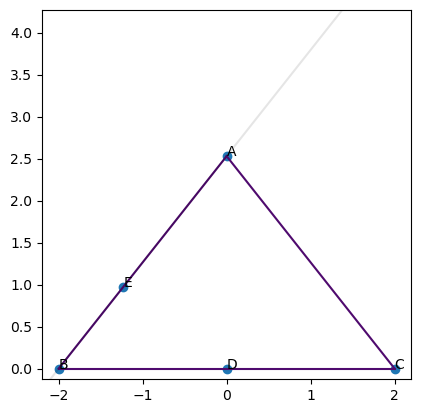

======== Print losses ==========
-- Losses --
  eq-n_(uangle B A C)_(mul 3.141592653589793 (div 2.0 5.0)) 0.0000187166
  points                                             0.0000027928
  distinct                                           0.0000000000
-- Goals --
  eq-n_(uangle A D E)_(mul 3.141592653589793 (div 1.0 5.0)) 0.0973416081
-- NDGs --


Found 1 models


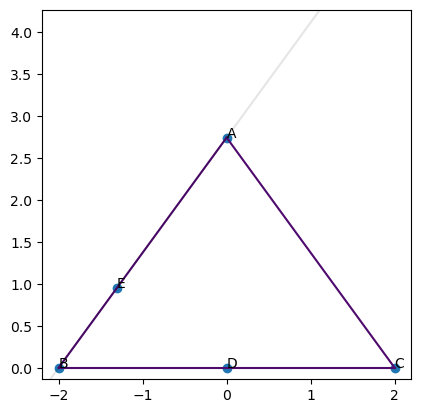

In [139]:
res = build(args)

In [140]:
for item in res[0]:
    print(item)

print('\n##############################################')

for item in res[1][0]:
    print(item)

(param (A B C) (iso-tri A))
(assert (= (uangle B A C) (mul pi (div 2 5))))
(define D point (midp B C))
(define E point (foot D (line A B)))
(eval (= (uangle A D E) (mul pi (div 1 5))))

##############################################
{<primitives.Point object at 0x00000214AB650520>: TfPoint(x=0.0, y=2.7402791294016904), <primitives.Point object at 0x00000214AB650A30>: TfPoint(x=-2.0, y=0.0), <primitives.Point object at 0x00000214AB650CA0>: TfPoint(x=2.0, y=0.0), <primitives.Point object at 0x00000214AB650E50>: TfPoint(x=0.0, y=0.0), <primitives.Point object at 0x00000214AB6503A0>: TfPoint(x=-1.3048996576074448, y=0.9523844805491437)}
{}
{}
[(TfPoint(x=0.0, y=2.7402791294016904), TfPoint(x=-2.0, y=0.0)), (TfPoint(x=-2.0, y=0.0), TfPoint(x=2.0, y=0.0)), (TfPoint(x=2.0, y=0.0), TfPoint(x=0.0, y=2.7402791294016904))]
[array([0.30793651, 0.03918341, 0.43156913]), array([0.30793651, 0.03918341, 0.43156913]), array([0.30793651, 0.03918341, 0.43156913])]
[]
[LineNF(n=TfPoint(x=-0.80774366528232

In [141]:
for obj_name, obj in res[1][0].named_points.items():
    print(obj_name)
    print(obj)
    (x, y) = obj

for obj_name, obj in res[1][0].named_lines.items():
    print(obj_name)
    print(obj)
    (x, y), r = obj
    # slope = y/x, intercept = r

for obj_name, obj in res[1][0].named_circles.items():
    print(obj_name)
    print(obj)
    (x, y), r = obj

A
(coords 0.000000 2.740279)
B
(coords -2.000000 0.000000)
C
(coords 2.000000 0.000000)
D
(coords 0.000000 0.000000)
E
(coords -1.304900 0.952384)
